# ROC by Activity Type, Confusion Matrix for activities, Random Forest  - 7-June-2017
----------------------------
## Summary
1. ROC Curves for Single Activity Detectors
2. Single Activity Detectors: Confusion Matrices
3. Random Forest: OOB rates for different number of estimators
4. Random Forest: Confusion Matrix
----------------------------

#### Imports 

In [1]:
%matplotlib inline
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
from sklearn import tree
from sklearn.decomposition import PCA
from sklearn import neighbors

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### Helper functions

In [2]:
# get data from the data file
def get_data(data_dict, data_id):
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file')
    df = pd.read_csv(file_name, index_col = 0)
    data = df.iloc[:,1:]
    target = df.fall
    return data_name, data, target

#gets data for a specific activity
def get_data_by_activity(data_dict, data_id, test_dict, activity_id):
    # read in data
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file')
    df = pd.read_csv(file_name, index_col = 0)
    # join with activity data 
    df = df.join(test_dict[['activity_id']])
    # select required activity and all falls
    data = df[ (df.activity_id == activity_id) | df.fall == 1]
    # get data and target 
    target = data['fall']
    data = data.drop(['fall','activity_id'], axis = 1)
    # get activity name
    dd = test_dict[test_dict.activity_id == activity_id].head(1)
    activity_name = dd.iloc[0,1]
    data_name = activity_name
    return data_name, data, target

# gets data with multiclass target
def get_data_multiclass(data_dict, data_id, test_dict):
    # read in data
    data_name = data_dict.get_value(data_id,'name')
    file_name = data_dict.get_value(data_id,'file')
    df = pd.read_csv(file_name, index_col = 0)
    # join with activity data 
    df = df.join(test_dict[['activity_id']])
    # for all falls ( i.e. with activity_id > = 9) set activity_id = 9 as a class label
    df.loc[df.activity_id > 9,'activity_id'] = 9
    # get data and target 
    target = df['activity_id']
    data = df.drop(['fall','activity_id'], axis = 1)
    return data_name, data, target

# normalises train data set as (X - mean / stdev) and applies the same scaling to test dataset 
def train_test_normalise(x_train, x_test):
    mean = x_train.mean().T
    std = x_train.std().T
    return ((x_train - mean)/std,(x_test - mean)/std) 

# returns model metrics for training and test sets
def model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='', data_name='', info=''):
    result = pd.DataFrame({'classifier': clf_name,
                           'data_set': data_name,
                           'num_feat': X_train.shape[1],  
                           'info': info,
                           'train_accuracy': metrics.accuracy_score(y_train, clf.predict(X_train)), 
                           'train_precision': metrics.precision_score(y_train, clf.predict(X_train)), 
                           'train_recall': metrics.recall_score(y_train, clf.predict(X_train)),
                           'test_accuracy': metrics.accuracy_score(y_test, clf.predict(X_test)), 
                           'test_precision': metrics.precision_score(y_test, clf.predict(X_test)), 
                           'test_recall': metrics.recall_score(y_test, clf.predict(X_test)),
                          },
                          index = [0])
    columns = ['classifier','data_set','num_feat','test_accuracy','test_precision','test_recall',
              'train_accuracy','train_precision','train_recall','info']
    result = result[columns]
    return result                                                                   

#### Read in data dictionary for available datasets

In [3]:
data_dict = pd.read_csv('data/data_dict.csv', index_col = 0)
data_dict

,name,desc,num_features,file,normalise
id,,,,,
1,magn_stats,Summary statistics on acceleration magnitude,8,data/magn_stats.csv,1
2,triax_stats,Summary statistics on triaxial acceleration,24,data/triax_stats.csv,1
3,magn_ts,Time series of acceleration magnitude,51,data/magn_ts.csv,0
4,triax_ts,Time series of triaxial accelaration - raw data,153,data/triax_ts.csv,0


In [4]:
test_dict = pd.read_csv('data/test_dict.csv')
test_dict = test_dict.set_index('test_id')
test_dict['subtype'].value_counts()

FALL            1699
running         1673
walking         1021
going_down       707
going_up         651
jumping          445
lying_down       260
getting_up       218
sitting_down     180
standing_up      159
Name: subtype, dtype: int64

In [5]:
# build activities dictionary
activity_dict = test_dict.drop_duplicates()
activity_dict = activity_dict.set_index('activity_id')
# get class names
class_names = np.array(activity_dict.iloc[0:10,:]['subtype'])
class_names

array(['standing_up', 'getting_up', 'walking', 'running', 'going_up',
       'jumping', 'going_down', 'lying_down', 'sitting_down', 'FALL'], dtype=object)

-------------------------------
## ROC curves for Classifiers based on Single Activity vs Falls

In [6]:
# regularisation params
Cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000,10000,100000]
param_grid = {'C': Cs, 'penalty':['l1','l2']}

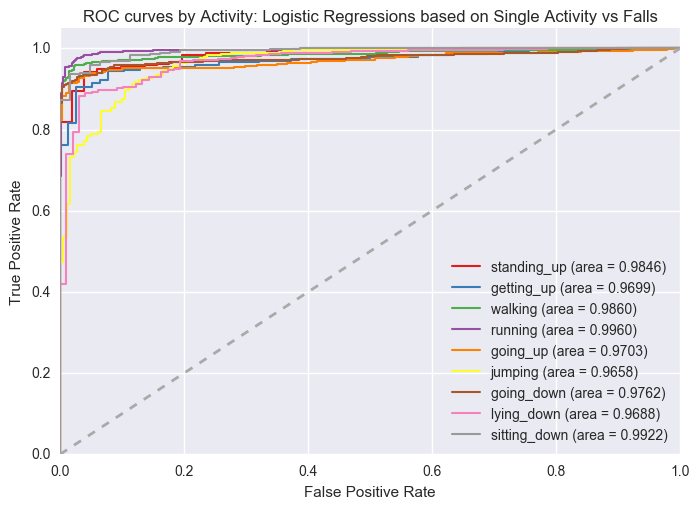

In [7]:
# using triax_stats
data_id = 2
res_store = pd.DataFrame()
# set colours
colour_num = 9
cmap = plt.get_cmap('Set1')
colours = [cmap(i) for i in np.linspace(0, 1, colour_num)]
# loop through activities and build classifiers
for i in range(0,9): 
    data_name, data, target = get_data_by_activity(data_dict,data_id,test_dict, i)
    data_desc = data_name
    need_normalise = data_dict.get_value(data_id,'normalise') 
    #split into training and test and normalise if required
    X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
    if (need_normalise == 1): 
        X_train, X_test = train_test_normalise(X_train, X_test)
    # train classifier
    clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
    clf.fit(X_train, y_train)
    y_score = clf.decision_function(X_test)
    #   record results
    mm =  model_metrics(clf, X_train, y_train, X_test, y_test, clf_name='LogRegr',data_name=data_desc, info=str(clf.best_params_))
    res_store = pd.concat([res_store, mm])
    #   plot ROC curve
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label= data_desc + ' (area = %0.4f)' % roc_auc, lw = 1.5, color = colours[i])
# Decorate plot
plt.plot([0, 1], [0, 1], color='darkgrey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curves by Activity: Logistic Regressions based on Single Activity vs Falls')
plt.legend(loc="lower right");
plt.savefig('plots/SingleActivityDetectors_ROC_curves.jpg');

In [8]:
# model performance by activity type
res_store[[1,3,4,5,6,7,8]].sort_values(by = 'test_accuracy', ascending = False )

,data_set,test_accuracy,test_precision,test_recall,train_accuracy,train_precision,train_recall
0,running,0.971090,0.984424,0.956127,0.975779,0.978703,0.973988
0,standing_up,0.970430,0.985528,0.982684,0.973070,0.982213,0.988072
0,sitting_down,0.969415,0.989721,0.976812,0.967169,0.980237,0.983152
0,walking,0.965074,0.984848,0.958702,0.970588,0.988945,0.963761
0,lying_down,0.946429,0.969388,0.969388,0.944681,0.963796,0.972359
0,going_up,0.939362,0.979032,0.932412,0.951064,0.980373,0.953244
0,going_down,0.938733,0.968992,0.941265,0.959113,0.981262,0.961353
0,getting_up,0.937419,0.970631,0.959361,0.950435,0.965787,0.978218
0,jumping,0.930070,0.941345,0.971935,0.923795,0.940000,0.965753


-----------------------
## Classifiers based on single activites : Confusion Matrix 

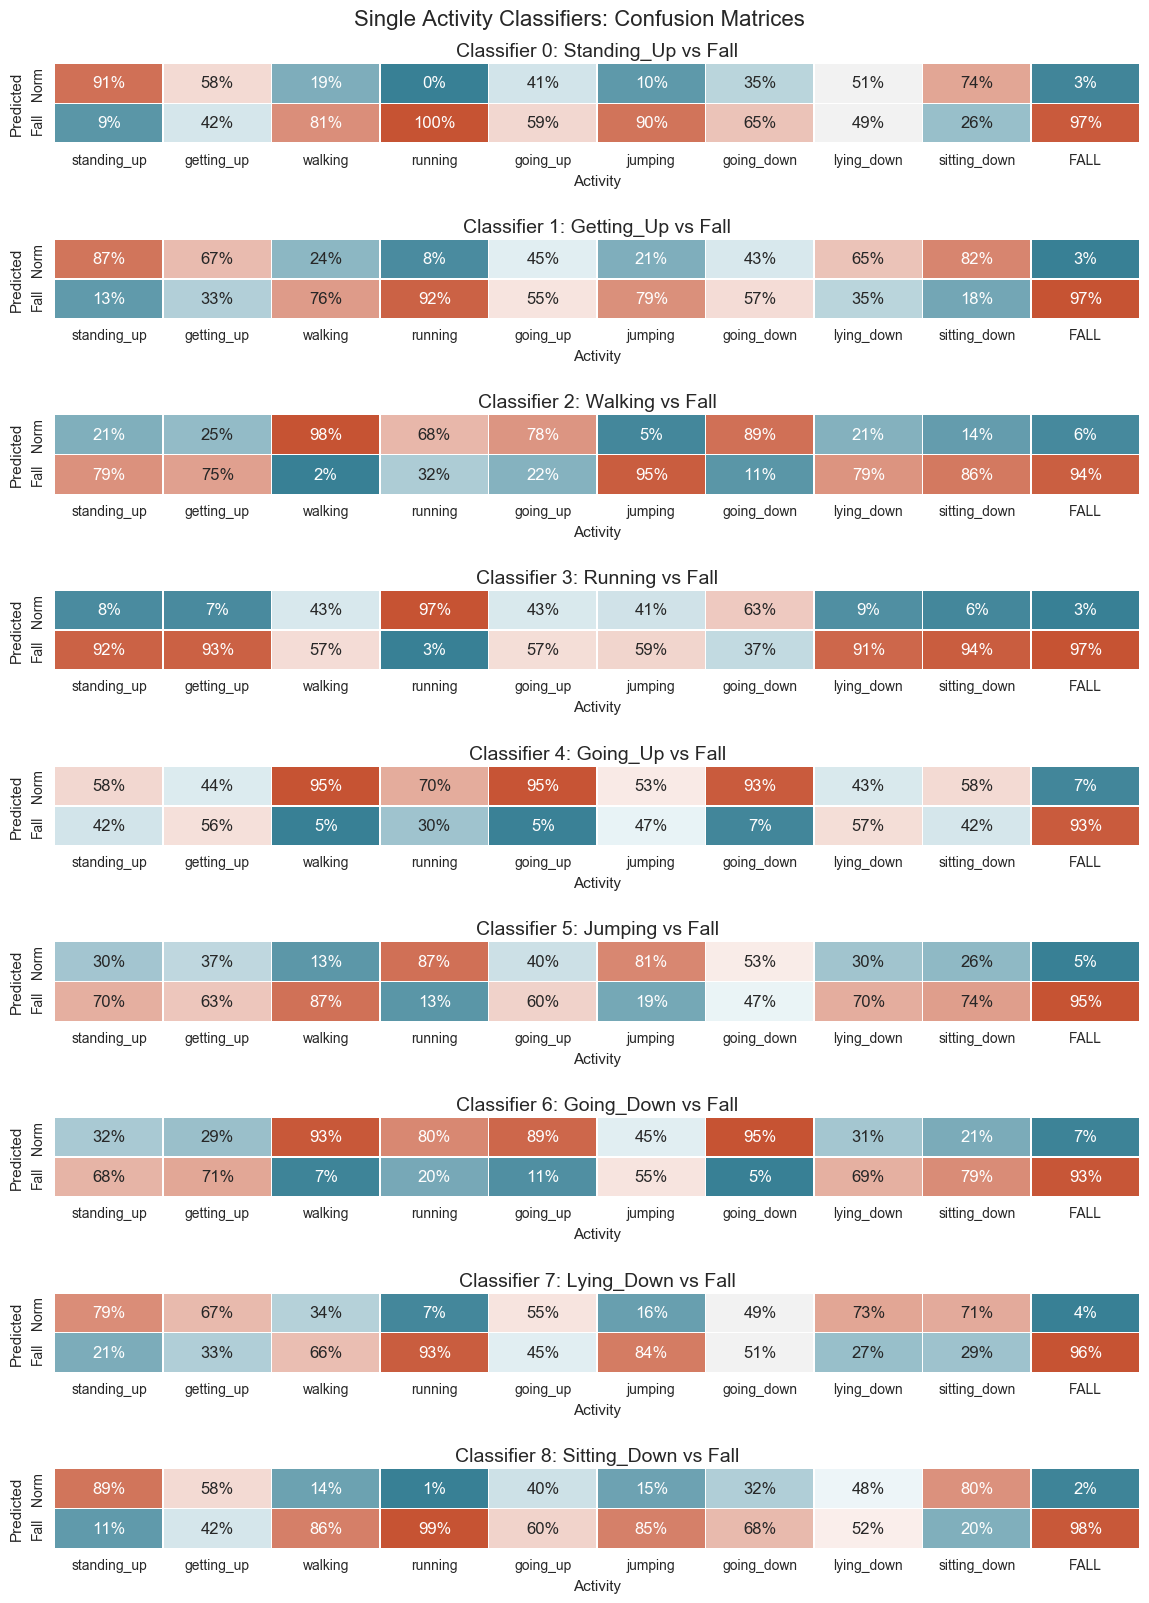

In [9]:
data_id = 2
data_name, data, target = get_data_multiclass(data_dict,data_id,test_dict)
need_normalise = data_dict.get_value(data_id,'normalise') 
#split into training and test and normalise if required
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
if (need_normalise == 1): 
    X_train, X_test = train_test_normalise(X_train, X_test)

num_activities = 9    
f, ax  = plt.subplots(num_activities,1, figsize=(14,18))    
    
fall_id = 9    
cmap = sns.diverging_palette(220, 20,s=80, as_cmap=True)
# loop through activity types 
for activity_id in range(0,num_activities):
    #get activity name
    activity_name = activity_dict.get_value(activity_id,'activity')
    # in training set : select data for a specific activity and all falls
    X_train_single_activity = X_train[(y_train == activity_id) | (y_train == fall_id )]
    y_train_single_activity = y_train[(y_train == activity_id) | (y_train == fall_id )]
    # train classifier on single activity training set 
    clf = GridSearchCV(LogisticRegression(), param_grid, cv = 5)
    clf.fit(X_train_single_activity, y_train_single_activity) 
    # calculate confusion matrix for Test Set 
    conf_matrix = metrics.confusion_matrix(y_test, clf.predict(X_test))
    conf_matrix = pd.DataFrame(conf_matrix, index = class_names)
    # keep predicted class only for this activity and fall ( other values are zeros)
    conf_matrix = conf_matrix[[activity_id,fall_id]]
    conf_matrix.columns = ['Norm','Fall']
    # normalise confusion matrix
    conf_matrix_norm = conf_matrix.divide(conf_matrix.sum(axis = 1),axis = 0)
    # plot confusion matrix 
    sns.heatmap(conf_matrix_norm.T,annot=True, fmt=".0%",cbar=False,linewidths=.3, 
                 annot_kws={"size": 12}, ax = ax[activity_id],cmap = cmap);
    ax[activity_id].set_title('Classifier ' + str(activity_id) + ': '+ activity_name.title() + ' vs Fall' ,fontsize=14)
    ax[activity_id].set_ylabel('Predicted')
    ax[activity_id].set_xlabel('Activity')
# decorate plot    
plt.subplots_adjust(hspace=1.2,top=0.95)
plt.suptitle('Single Activity Classifiers: Confusion Matrices', fontsize=16);
f.savefig('plots/SingleActivityDetectors_ConfusionMatrices.jpg');

--------------------
## Random forest

In [10]:
from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

### Random forest - OOB error rates 

/Users/annazamaraeva/anaconda/lib/python2.7/site-packages/sklearn/ensemble/forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


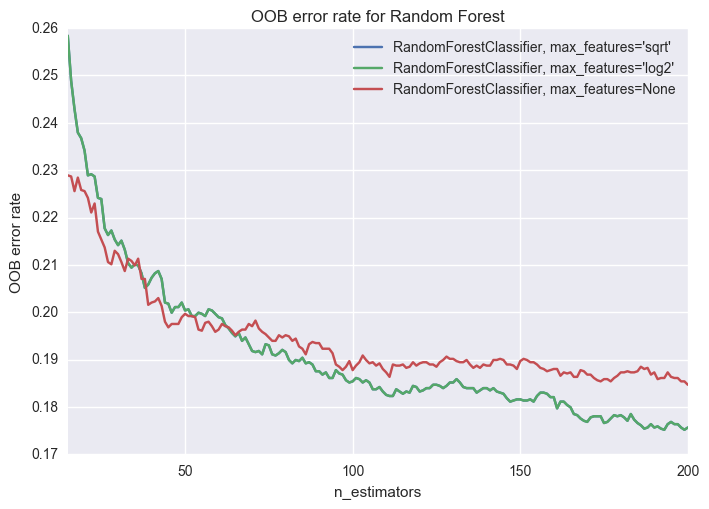

In [11]:
RANDOM_STATE = 13

ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)) ,
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.title('OOB error rate for Random Forest');

### Confusion Matrix for Random Forest 1

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='log2', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=190, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy - Train set:  1.0
Accuracy - Test set:  0.842480399145


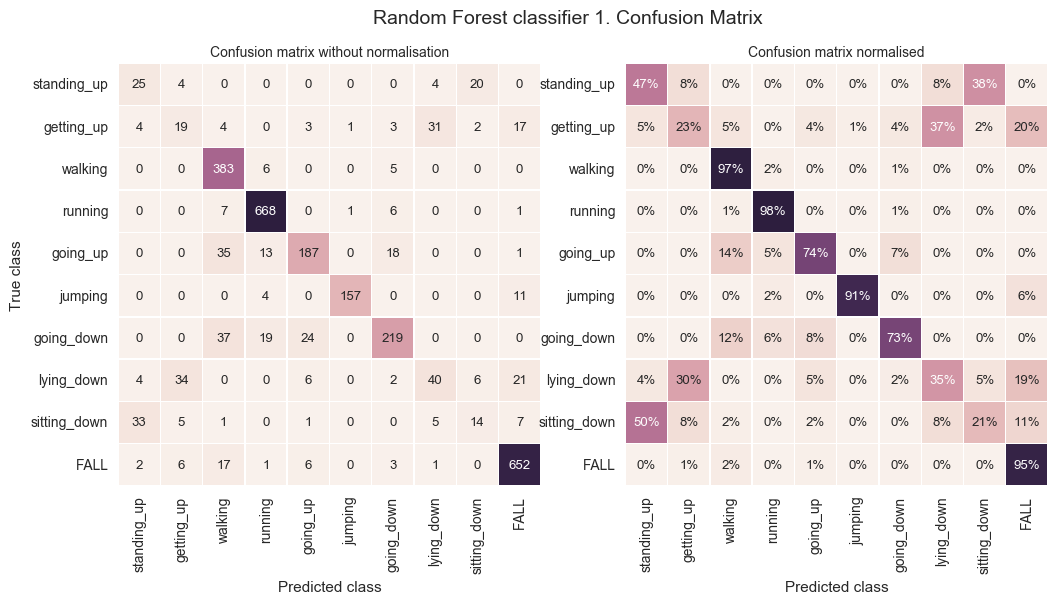

In [12]:
# run multiclass random forest on traxial statistics data
data_id = 2
data_name, data, target = get_data_multiclass(data_dict,data_id,test_dict)
need_normalise = data_dict.get_value(data_id,'normalise') 

#split into training and test and normalise if required
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
if (need_normalise == 1): 
    X_train, X_test = train_test_normalise(X_train, X_test)

#train classifier
clf = RandomForestClassifier(max_features='log2',n_estimators =190)
clf.fit(X_train, y_train)
print clf
print 'Accuracy - Train set: ' , metrics.accuracy_score(y_train, clf.predict(X_train))
print 'Accuracy - Test set: ' , metrics.accuracy_score(y_test, clf.predict(X_test))

# get confusion matrix 
conf_matrix = metrics.confusion_matrix(y_test, clf.predict(X_test))
conf_matrix = pd.DataFrame(conf_matrix,columns = class_names, index = class_names)
# normalise confusion matrix
conf_matrix_norm = conf_matrix.divide(conf_matrix.sum(axis = 1),axis = 0)

# plot confusion matrices
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
sns.heatmap(conf_matrix,annot=True, fmt="d",cbar=False,linewidths=.3, square = True, annot_kws={"size": 9.5}, ax = ax1);
ax1.set_title('Confusion matrix without normalisation',fontsize=10)
ax1.set_xlabel('Predicted class')
ax1.set_ylabel('True class');
sns.heatmap(conf_matrix_norm,annot=True, fmt = '.0%', cbar=False,linewidths=.3,annot_kws={"size": 9.5}, square = True, ax = ax2);
ax2.set_title('Confusion matrix normalised',fontsize=10);
ax2.set_xlabel('Predicted class')
plt.subplots_adjust(wspace=0.2,top = 0.95)
plt.suptitle('Random Forest classifier 1. Confusion Matrix',fontsize=14);

### Random Forest 2

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=190, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)
Accuracy - Train set:  1.0
Accuracy - Test set:  0.820384889522


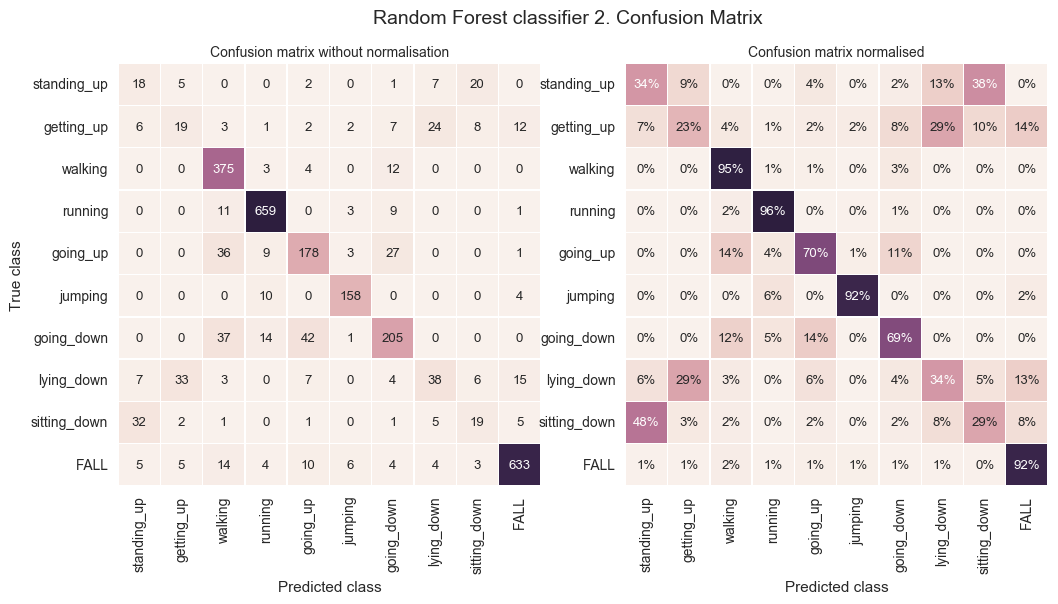

In [13]:
# run multiclass random forest on traxial statistics data
data_id = 2
data_name, data, target = get_data_multiclass(data_dict,data_id,test_dict)
need_normalise = data_dict.get_value(data_id,'normalise') 

#split into training and test and normalise if required
X_train, X_test, y_train, y_test = train_test_split(data, target, random_state = 42, test_size = 0.4)
if (need_normalise == 1): 
    X_train, X_test = train_test_normalise(X_train, X_test)

#train classifier
clf = RandomForestClassifier(max_features=None,n_estimators =190)
clf.fit(X_train, y_train)
print clf
print 'Accuracy - Train set: ' , metrics.accuracy_score(y_train, clf.predict(X_train))
print 'Accuracy - Test set: ' , metrics.accuracy_score(y_test, clf.predict(X_test))

# get confusion matrix 
conf_matrix = metrics.confusion_matrix(y_test, clf.predict(X_test))
conf_matrix = pd.DataFrame(conf_matrix,columns = class_names, index = class_names)
# normalise confusion matrix
conf_matrix_norm = conf_matrix.divide(conf_matrix.sum(axis = 1),axis = 0)

# plot confusion matrices
f,(ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
sns.heatmap(conf_matrix,annot=True, fmt="d",cbar=False,linewidths=.3, square = True, annot_kws={"size": 9.5}, ax = ax1);
ax1.set_title('Confusion matrix without normalisation',fontsize=10)
ax1.set_xlabel('Predicted class')
ax1.set_ylabel('True class');
sns.heatmap(conf_matrix_norm,annot=True, fmt = '.0%', cbar=False,linewidths=.3,annot_kws={"size": 9.5}, square = True, ax = ax2);
ax2.set_title('Confusion matrix normalised',fontsize=10);
ax2.set_xlabel('Predicted class')
plt.subplots_adjust(wspace=0.2,top = 0.95)
plt.suptitle('Random Forest classifier 2. Confusion Matrix',fontsize=14);